# Toxic Comment Dataset – Data Preparation & Exploration

Discussing things you care about can be difficult. The threat of abuse and harassment online means that many people stop expressing themselves and give up on seeking different opinions. Platforms struggle to effectively facilitate conversations, leading many communities to limit or completely shut down user comments.

Our Goal is to create a Deep learning model to detect toxicity and to classify them.

Goal of this notebook:
- Load the raw training data
- Inspect the structure of the dataset
- Explore the label distribution (multi-label problem)
- Look at text length and basic properties
- Apply a light, model-friendly text cleaning
- Save a clean version of the dataset (and optional train/valid split)

The idea is to keep the text close to its original form (good for Transformers)
while removing the worst noise (line breaks, extra spaces, raw URLs, HTML tags)

# Basic setup

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re
import unicodedata
from sklearn.metrics import (
    f1_score,
    precision_recall_fscore_support,
    classification_report,
    hamming_loss,
    accuracy_score,
    average_precision_score,
    confusion_matrix,
    roc_auc_score
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
from torch.optim import AdamW
from tqdm.auto import tqdm

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    get_linear_schedule_with_warmup
)
from torch.utils.data import Dataset, WeightedRandomSampler, DataLoader

# Plot style
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

# Reproductibilité
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

print("Imports terminés.")

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using device: CUDA")
else:
    device = torch.device("cpu")
    print("Using device: CPU")

Imports terminés.
Using device: cpu


# Dataset Preprocessing

## Import Dataset

In [2]:
file_path = "data/train.csv"

# Read file (try common encodings)
df = pd.read_csv(file_path, encoding='utf-8', low_memory=False)
print("Shape:", df.shape)
df.head()

Shape: (159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## Quick look

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In this dataset, each comment can have multiple labels:

- toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate
  
This is a multi-label classification problem (not just one class per row).

This is a multi-label setup: each comment can belong to several categories at the same time
(e.g. both `toxic` and `insult`). This will influence the choice of loss function later
(sigmoid outputs + binary cross-entropy instead of a softmax).

Check for missing values in the main columns.

In [4]:
label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

df[["id", "comment_text"] + label_cols].isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

## Label Distribution

First, let's count how many times each label appears.

Counts (0 vs 1) for each label


,count_0,count_1
label,,
toxic,144277,15294
severe_toxic,157976,1595
obscene,151122,8449
threat,159093,478
insult,151694,7877
identity_hate,158166,1405


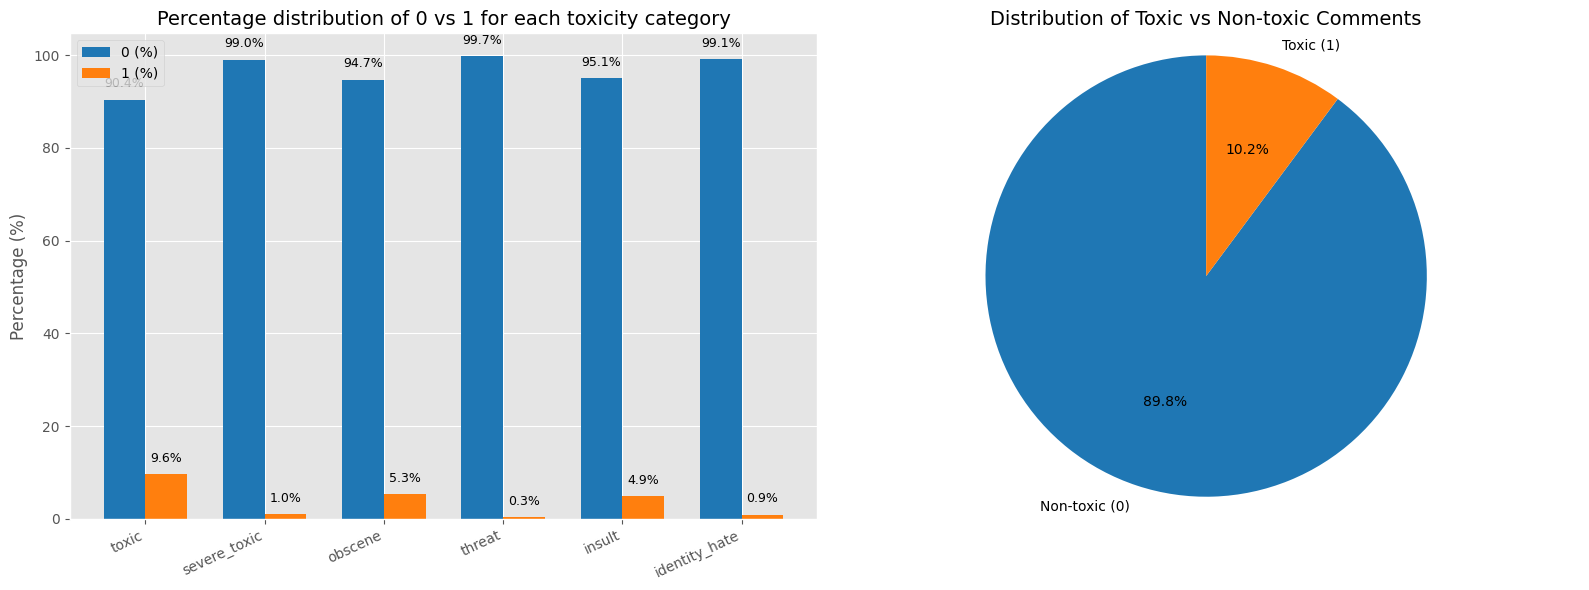

In [5]:
# Create a binary 'detect_toxic' column:
# 1 if the text is classified as toxic in at least one category (any 1 in label_cols),
# 0 if it is not toxic in any category.
df['detect_toxic'] = df[label_cols].max(axis=1).astype(int)


# Compute counts for 0 and 1 for each label
counts = []
for c in label_cols:
    vc = df[c].value_counts().to_dict()
    counts.append({'label': c, 'count_0': vc.get(0, 0), 'count_1': vc.get(1, 0)})
counts_df = pd.DataFrame(counts).set_index('label')

print("Counts (0 vs 1) for each label")
display(counts_df)


# Compute percentages for each label (avoid division by zero)
total_per_label = counts_df['count_0'] + counts_df['count_1']
total_per_label = total_per_label.replace(0, np.nan)  # avoid div by zero
pct_0 = (counts_df['count_0'] / total_per_label) * 100
pct_1 = (counts_df['count_1'] / total_per_label) * 100
pct_0 = pct_0.fillna(0)
pct_1 = pct_1.fillna(0)

# Summary table with counts + percentages (optional display)
summary_df = counts_df.copy()
summary_df['pct_0'] = pct_0.round(1)
summary_df['pct_1'] = pct_1.round(1)


# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot grouped bar chart (percentages) on the left subplot
labels = counts_df.index.tolist()
count_0_pct = pct_0.values
count_1_pct = pct_1.values

x = np.arange(len(labels))
width = 0.35

# Colors (blue/orange)
color_0 = '#1f77b4'  # blue
color_1 = '#ff7f0e'  # orange

ax1.bar(x - width/2, count_0_pct, width, label='0 (%)', color=color_0)
ax1.bar(x + width/2, count_1_pct, width, label='1 (%)', color=color_1)

ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=25, ha='right')
ax1.set_ylabel('Percentage (%)')
ax1.set_title('Percentage distribution of 0 vs 1 for each toxicity category')
ax1.legend()

# Annotate percentages on top of bars
y_offset = max(np.max(count_0_pct), np.max(count_1_pct)) * 0.02 if len(labels) > 0 else 1
for i in range(len(x)):
    ax1.text(x[i] - width/2, count_0_pct[i] + y_offset, f"{count_0_pct[i]:.1f}%", 
             ha='center', va='bottom', fontsize=9)
    ax1.text(x[i] + width/2, count_1_pct[i] + y_offset, f"{count_1_pct[i]:.1f}%", 
             ha='center', va='bottom', fontsize=9)


# Pie chart for detect_toxic (also blue/orange)
if 'detect_toxic' in df.columns:
    toxic_counts = df['detect_toxic'].value_counts()
    sizes = [int(toxic_counts.get(0, 0)), int(toxic_counts.get(1, 0))]

    if sum(sizes) == 0:
        ax2.text(0.5, 0.5, "No data for 'detect_toxic'", ha='center', va='center')
    else:
        pie_labels = ['Non-toxic (0)', 'Toxic (1)']
        ax2.pie(
            sizes,
            labels=pie_labels,
            autopct='%1.1f%%',
            startangle=90,
            colors=[color_0, color_1]   # <-- Blue & Orange
        )
        ax2.axis('equal')
        ax2.set_title('Distribution of Toxic vs Non-toxic Comments')
        # print(f"Non-toxic (0): {sizes[0]}")
        # print(f"Toxic (1): {sizes[1]}")
else:
    ax2.text(0.5, 0.5, "Column 'detect_toxic' not found", ha='center', va='center')

plt.tight_layout()
plt.show()

### Note on label imbalance

The label distribution is very  skewed. Some labels like `toxic` are relatively frequent,
while others such as `severe_toxic`, `threat` or `identity_hate` are rare.

This has a few consequences for the next phases of the project:

- A simple accuracy score will be misleading.
- The model may focus on the frequent labels and almost ignore the rare ones.
- Metrics for rare labels will be noisy, especially on a small validation set.

Later, during training, I will need to:
- Track per-label metrics (F1, precision, recall).
- Consider using class weights, focal loss or some form of oversampling for rare labels.
- Tune thresholds per label instead of using a single 0.5 cut-off.

### How many labels per comment?

For each comment, we can count how many labels are active (0 to 6).

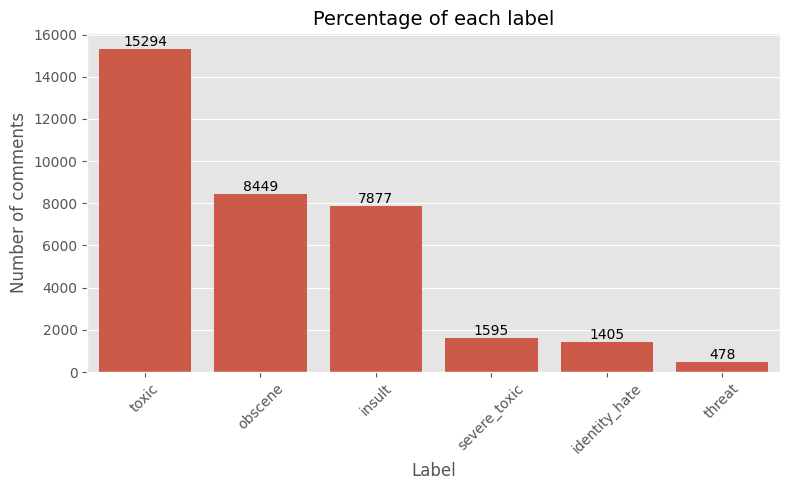

In [6]:
label_counts = df[label_cols].sum().sort_values(ascending=False)
total = len(df)

# Plot label counts as a bar chart.
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=label_counts.index, y=label_counts.values)

# Ajouter les pourcentages au-dessus des barres
for p in ax.patches:
    height = p.get_height()
    #percent = (height / total) * 100
    percent = height
    ax.annotate(
        f"{int(percent)}",                      # format pourcentage
        (p.get_x() + p.get_width() / 2, height),
        ha='center', va='bottom', fontsize=10
    )

plt.title("Percentage of each label")
plt.ylabel("Number of comments")
plt.xlabel("Label")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Text length analysis

It's useful to know how long the comments are.
This helps decide on a maximum sequence length for the model later.

### Per character

We count by character every comment to see the repartition

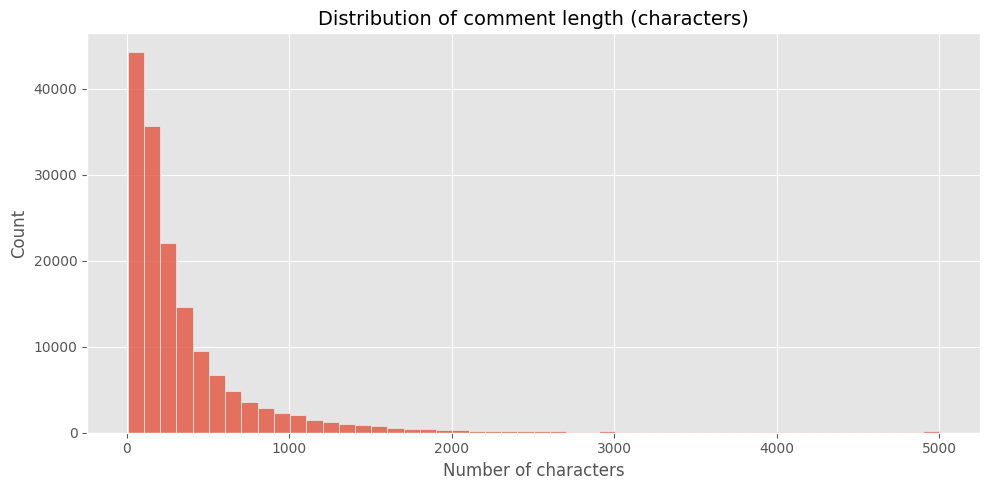

In [7]:
df["text_length"] = df["comment_text"].astype(str).str.len()

# plot the distribution
plt.figure(figsize=(10, 5))
sns.histplot(df["text_length"], bins=50)
plt.title("Distribution of comment length (characters)")
plt.xlabel("Number of characters")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

We can also compare length distributions between toxic and non-toxic, using the column detect_toxic label .

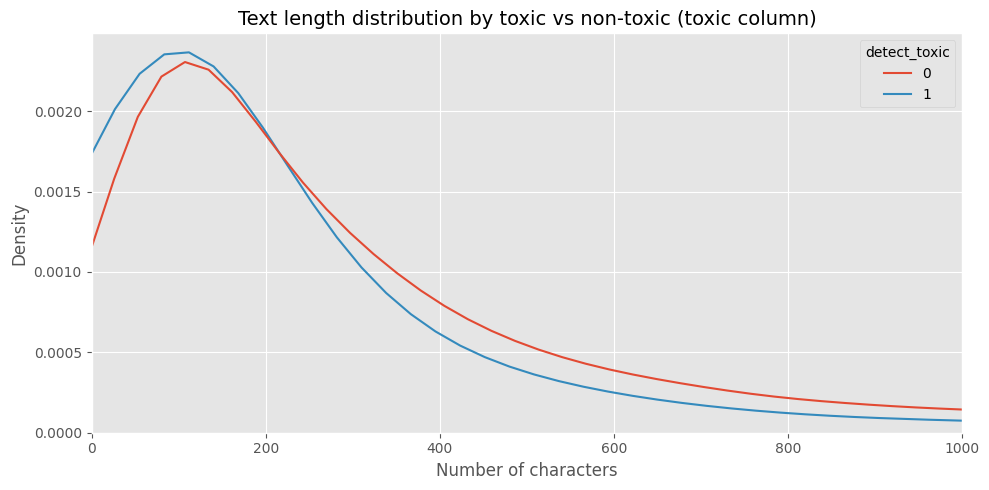

In [8]:
plt.figure(figsize=(10, 5))
sns.kdeplot(
    data=df,
    x="text_length",
    hue="detect_toxic",
    common_norm=False,
    bw_adjust=1.2,
)
plt.xlim(0, 1000)  # limit for readability
plt.title("Text length distribution by toxic vs non-toxic (toxic column)")
plt.xlabel("Number of characters")
plt.tight_layout()
plt.show()

### Per word

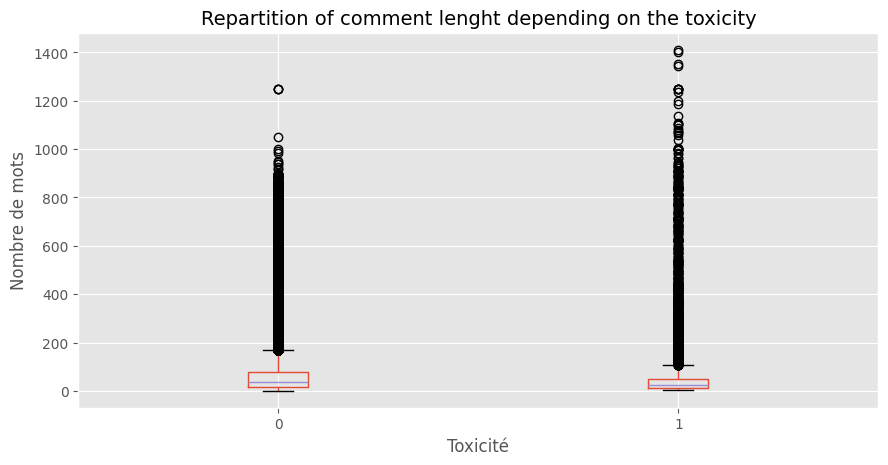

In [9]:
# I want to know the number of word in every comment to know the average
df["nb_mots"] = df["comment_text"].str.split().str.len()

#test to check the relation between comment lenght and comment toxicity
df.boxplot(column="nb_mots", by="detect_toxic")
plt.title("Repartition of comment lenght depending on the toxicity")
plt.suptitle("")
plt.xlabel("Toxicité")
plt.ylabel("Nombre de mots")
plt.show()

We notice that there is no relation between Toxicity message and number of words or number of charcters. We could add or delete word. There will not have impact on our prediction

## Text Cleaning

In [10]:
# Pre-compiled regex patterns for performance
RE_URL = re.compile(r'https?://\S+|www\.\S+', flags=re.IGNORECASE)  # Detect URLs
RE_IP = re.compile(r'(([0-9]{1,3}\.){2,}[0-9]{1,3})')               # Detect IP addresses (basic IPv4 format)
RE_SYM_REPEAT = re.compile(r'([*!?.,;:()\[\]"\-—–])\1{2,}')         # Symbol repeated 3+ times
RE_LETTER_REPEAT = re.compile(r'([^\W\d_])\1{2,}', flags=re.UNICODE)  # Letter repeated 3+ times
RE_MULTI_SPACE = re.compile(r'\s{2,}')                              # Multiple spaces

def normalize_unicode(text):
    """
    Normalize unicode characters to a consistent representation (NFKC).
    This preserves accents while normalizing different forms of the same character.
    """
    return unicodedata.normalize('NFKC', text)

def clean_text_series(s: pd.Series,
                      lower: bool = True,
                      url_token: str = "[URL]",
                      ip_token: str = "[IP]",
                      max_letter_repeats: int = 2,
                      keep_sym_repeat_max: int = 3) -> pd.Series:
    """
    Clean a pandas Series of text efficiently using vectorized operations.

    Parameters:
    - lower: convert text to lowercase (disable for case-sensitive language models like BERT-base-cased)
    - url_token: token replacing detected URLs (keeps semantic value)
    - ip_token: token replacing detected IP addresses
    - max_letter_repeats: limit for character repetitions (e.g., "fuuuuck" → "fuuck" if set to 2)
    - keep_sym_repeat_max: limit for punctuation repetitions (e.g., "!!!!!" → "!!!")
    """

    s = s.astype(str).fillna("")   # Ensure text format + remove NaN
    s = s.map(normalize_unicode)   # Normalize unicode representation

    if lower:
        s = s.str.lower()

    # Replace URLs without adding extra whitespace
    s = s.str.replace(RE_URL, url_token, regex=True)

    # Replace IPs
    s = s.str.replace(RE_IP, ip_token, regex=True)

    # Remove newlines instead of replacing by token with spaces
    s = s.str.replace(r'\r\n|\r|\n', ' ', regex=True)

    # Reduce repeating punctuation marks
    def sym_repl(m):
        return m.group(1) * keep_sym_repeat_max
    s = s.str.replace(RE_SYM_REPEAT, lambda m: sym_repl(m), regex=True)

    # Reduce exaggerated letter repetitions
    if max_letter_repeats >= 1:
        def letter_repl(m):
            ch = m.group(1)
            return ch * max_letter_repeats
        s = s.str.replace(RE_LETTER_REPEAT, lambda m: letter_repl(m), regex=True)

    # Remove spacing rules around punctuation (no added spaces)
    
    # Replace emails with token
    s = s.str.replace(r'\b[\w\.-]+@[\w\.-]+\.\w{2,}\b', '[EMAIL]', regex=True)

    # Cleanup multiple spaces
    s = s.str.replace(RE_MULTI_SPACE, ' ', regex=True).str.strip()

    return s

In [11]:
# Apply this to our dataset 
df["clean_comment"] = clean_text_series(
    df["comment_text"],
    lower=True,
    url_token='[URL]',
    ip_token='[IP]',
    max_letter_repeats=2
)

# Dislpay
print('dataframe Shape :', df.shape)
df.head()

dataframe Shape : (159571, 12)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,detect_toxic,text_length,nb_mots,clean_comment
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,264,43,explanation why the edits made under my userna...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,112,17,d'aww! he matches this background colour i'm s...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,233,42,"hey man, i'm really not trying to edit war. it..."
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,622,113,""" more i can't make any real suggestions on im..."
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,67,13,"you, sir, are my hero. any chance you remember..."


In [12]:
# Check if cleaning introduced any empty strings.
empty_mask = df["clean_comment"].str.len() == 0
print("Number of empty cleaned comments:", empty_mask.sum())

Number of empty cleaned comments: 0


Here is an example: 

<u>We have started from this</u> :
_Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27_

<u>to this</u>:
_explanation why the edits made under my username hardcore metallica fan were reverted? they weren't vandalisms, just closure on some gas after i voted at new york dolls fac. and please don't remove the template from the talk page since i'm retired now.[IP]_

## Train / Validation split

For deep learning, it is handy to split now and reuse the same split later. Multi-label stratification is more complicated, so we keep it simple for now.

For our project, we use a simple **90/10 train/validation split**.

To keep at least a basic balance between "toxic" and "non-toxic", We create a
binary indicator `detect_toxic` (1 = at least one toxic label, 0 = no label) and perform stratified splitting on this feature.


This method offers only a limited solution for multi-label datasets:

- The split guarantees balance only for "has any label" vs "no label".

- Rare labels, such as `threat` or `identity_hate`, may remain underrepresented in the validation set.

- Metrics for these infrequent labels will likely be unstable.


For future improvements and more robust evaluations, we could consider:

- Iterative multi-label stratification algorithms.

- Increasing validation set size (e.g., 15–20%) to boost representation of rare labels.

- Employing cross-validation instead of a single split.

For now, this straightforward split is adequate, though its limitations should be kept in mind.

In [13]:
#Select columns 
df = df[["id", "comment_text", "clean_comment","detect_toxic","toxic",
          "severe_toxic","obscene","threat","insult","identity_hate"]]

train_df, valid_df = train_test_split(
    df,
    test_size=0.1,
    random_state=SEED,
    stratify=df["detect_toxic"],  # simple stratification
)

# Display
print('DF shape:', df.shape)
print("Train dataset shape", train_df.shape)
print("Valid dataset shape", valid_df.shape)
print("-------------------------------------")
print("\nLabel ratios in TRAIN:")
print((train_df[label_cols].sum() / len(train_df)).round(3))

print("\nLabel ratios in VALID:")
print((valid_df[label_cols].sum() / len(valid_df)).round(3))

DF shape: (159571, 10)
Train dataset shape (143613, 10)
Valid dataset shape (15958, 10)
-------------------------------------

Label ratios in TRAIN:
toxic            0.096
severe_toxic     0.010
obscene          0.053
threat           0.003
insult           0.049
identity_hate    0.009
dtype: float64

Label ratios in VALID:
toxic            0.096
severe_toxic     0.009
obscene          0.052
threat           0.003
insult           0.049
identity_hate    0.008
dtype: float64


## Save Clean data

In [14]:
OUTPUT_DIR = "./data/processed"
os.makedirs(OUTPUT_DIR, exist_ok=True)

full_path_csv = os.path.join(OUTPUT_DIR, "train_clean_full.csv")
train_path_csv = os.path.join(OUTPUT_DIR, "train_clean.csv")
valid_path_csv = os.path.join(OUTPUT_DIR, "valid_clean.csv")

df.to_csv(full_path_csv, index=False)
train_df.to_csv(train_path_csv, index=False)
valid_df.to_csv(valid_path_csv, index=False)

# Model

This notebook uses the cleaned data produced in the previous step (`train_clean.csv` and `valid_clean.csv`) to:

1. Build a simple baseline model:
   - TF-IDF on `comment_clean`
   - One-vs-Rest Logistic Regression

The baseline model is the simplest possible model, used as a point of comparison to evaluate if more advanced models improve performance.

2. Fine-tune two advanced Transformer models:
   - DistilBERT (fine-tuned)
   - bert-base-uncased (fine-tuned)

3. Compare the baseline and these two advanced models using:
   - Macro and micro F1 scores
   - Per-label F1 scores
   - Simple visual comparisons of performance

The goal is to establish a clear baseline, have reproducible deep learning models, and decide which model is the most effective for the task.


## Label Setup

This is a multi-label classification problem: each comment can belong to several toxicity categories at once.

In [15]:
label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# Sanity check
for col in label_cols:
    assert col in train_df.columns, f"Missing label {col} in train_df"
    assert col in valid_df.columns, f"Missing label {col} in valid_df"

print("Label columns:", label_cols)
print("-----------------------------------")

# Extract X and y for convenience
X_train_text = train_df["clean_comment"].astype(str).values
X_valid_text = valid_df["clean_comment"].astype(str).values

y_train = train_df[label_cols].values
y_valid = valid_df[label_cols].values

#Display
print("X_train_text shape:", X_train_text.shape)
print("y_train shape:", y_train.shape)
print("-----------------------------------")
print("X_valid_text shape:", X_valid_text.shape)
print("y_valid shape:", y_valid.shape)

Label columns: ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
-----------------------------------
X_train_text shape: (143613,)
y_train shape: (143613, 6)
-----------------------------------
X_valid_text shape: (15958,)
y_valid shape: (15958, 6)


## Baseline model: TF-IDF + Logistic Regression (One-vs-Rest)

This baseline is deliberately simple:

- TF-IDF representation of the cleaned text
- One-vs-Rest Logistic Regression for multi-label classification
  
It gives a reasonable benchmark before switching to the Transformer model.

### Vectorize our dataset

In [16]:
%%time
tfidf = TfidfVectorizer(
    max_features=100_000,  # adjust if needed
    ngram_range=(1, 2),    # unigrams + bigrams
    min_df=3,
    max_df=0.9,
)

X_train_tfidf = tfidf.fit_transform(X_train_text)
X_valid_tfidf = tfidf.transform(X_valid_text)

# Display
print('X_train shape :', X_train_text.shape)
print('X_train encoded shape :', X_train_tfidf.shape)
print('----------------------------------------------')
print('X_valid shape :', X_valid_text.shape)
print('X_valid encoded shape :', X_valid_tfidf.shape)

X_train shape : (143613,)
X_train encoded shape : (143613, 100000)
----------------------------------------------
X_valid shape : (15958,)
X_valid encoded shape : (15958, 100000)
CPU times: total: 24.8 s
Wall time: 24.9 s


### Model building

_Baseline model_: One-vs-Rest Logistic Regression

We use a simple Logistic Regression classifier as a baseline.
Since this is a multi-label problem (a comment can have multiple toxicity labels),
we wrap it in a OneVsRestClassifier, which trains one binary classifier per label.

`C` and `max_iter` can be tuned later if needed.

In [17]:
%%time
logreg = OneVsRestClassifier(
    LogisticRegression(
        C=4.0, #Inverse of regularization strength (higher C → less regularization)
        max_iter=200, #Maximum number of iterations for convergence
        n_jobs=-1, #Use all CPU cores for parallel training
        solver="lbfgs", #Optimization algorithm
    )
)

logreg.fit(X_train_tfidf, y_train)

print("Baseline model fitted.")

Baseline model fitted.
CPU times: total: 859 ms
Wall time: 46.4 s


### Baseline evaluation on validation set

In [18]:
%%time

# Probabilities and predictions
y_valid_proba_base = logreg.predict_proba(X_valid_tfidf)
y_valid_pred_base = (y_valid_proba_base >= 0.5).astype(int)  # threshold 0.5

# -----------------------
# Global F1 scores
f1_micro_base = f1_score(y_valid, y_valid_pred_base, average="micro", zero_division=0)
f1_macro_base = f1_score(y_valid, y_valid_pred_base, average="macro", zero_division=0)

print(f"Baseline TF-IDF + LogReg  |  F1 micro: {f1_micro_base:.4f}  |  F1 macro: {f1_macro_base:.4f}")

# -----------------------
# Per-label precision, recall, F1
prec, rec, f1_per_label, support = precision_recall_fscore_support(
    y_valid, y_valid_pred_base, average=None, zero_division=0
)

baseline_results = pd.DataFrame(
    {
        "label": label_cols,
        "precision": prec,
        "recall": rec,
        "f1": f1_per_label,
        "support": support,
    }
)

# Hamming Loss (fraction of misclassified labels)
hamming = hamming_loss(y_valid, y_valid_pred_base)

# Subset Accuracy (exact match ratio)
subset_acc = accuracy_score(y_valid, y_valid_pred_base)

# Average Precision and ROC-AUC (macro)
avg_precision = average_precision_score(y_valid, y_valid_proba_base, average='macro')
roc_auc = roc_auc_score(y_valid, y_valid_proba_base, average='macro')

print(f"Hamming Loss: {hamming:.4f}  |  Subset Accuracy: {subset_acc:.4f}")
print(f"Average Precision (macro): {avg_precision:.4f}  |  ROC-AUC (macro): {roc_auc:.4f}")

baseline_results

Baseline TF-IDF + LogReg  |  F1 micro: 0.7108  |  F1 macro: 0.5393
Hamming Loss: 0.0177  |  Subset Accuracy: 0.9210
Average Precision (macro): 0.6197  |  ROC-AUC (macro): 0.9756
CPU times: total: 109 ms
Wall time: 101 ms


,label,precision,recall,f1,support
0,toxic,0.909741,0.667541,0.770045,1525
1,severe_toxic,0.581081,0.300699,0.396313,143
2,obscene,0.896104,0.668281,0.765603,826
3,threat,0.714286,0.238095,0.357143,42
4,insult,0.791289,0.560411,0.656132,778
5,identity_hate,0.553191,0.196970,0.290503,132


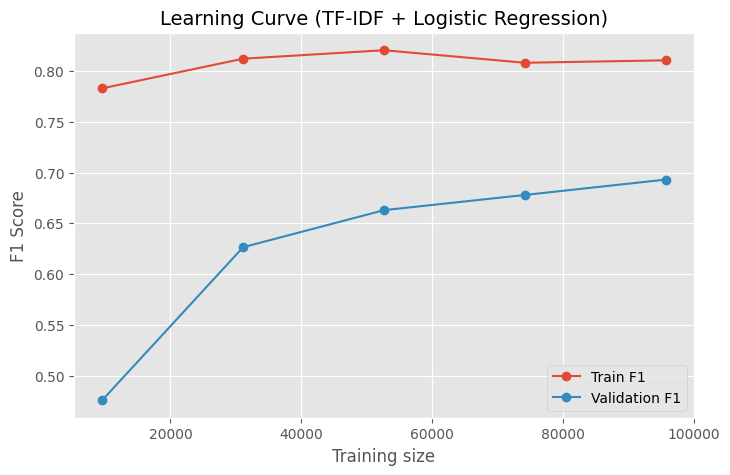

In [19]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    estimator=logreg,
    X=X_train_tfidf,
    y=y_train,
    cv=3,
    scoring="f1_micro",
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
valid_mean = valid_scores.mean(axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, marker="o", label="Train F1")
plt.plot(train_sizes, valid_mean, marker="o", label="Validation F1")
plt.xlabel("Training size")
plt.ylabel("F1 Score")
plt.title("Learning Curve (TF-IDF + Logistic Regression)")
plt.legend()
plt.show()

### Note

- **F1 micro:** 0.7152 | **F1 macro:** 0.5434 → handles frequent labels well, struggles on rare labels (threat, identity_hate).  
- **Hamming Loss:** 0.0176 → very few labels misclassified.  
- **Subset Accuracy:** 0.9216 → most examples have all labels correct, but can be misleading on imbalanced data.  
- **Average Precision (macro):** 0.6168 | **ROC-AUC (macro):** 0.9777 → probabilities are reliable.  

**Observation:** The baseline underfits on rare labels due to model simplicity (linear TF-IDF + Logistic Regression) and fixed threshold. Frequent labels are predicted well, but rare labels have low recall.

**About the learning curve**: 
- the baseline TF-IDF + Logistic Regression model improves with more data, but its generalization remains limited.

- The gap between training and validation F1 indicates it mainly captures simple relationships and risks mild overfitting.

This baseline provides a good reference to evaluate the added value of more advanced models.


### Baseline per-label F1 scores

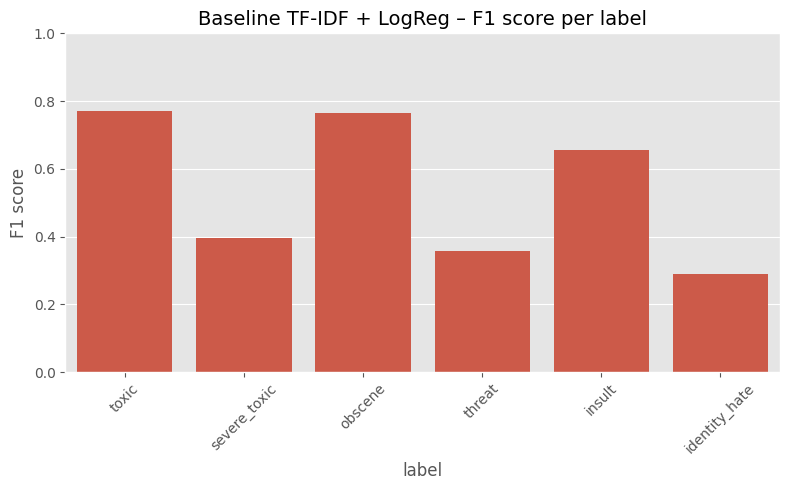

In [20]:
plt.figure(figsize=(8, 5))
sns.barplot(data=baseline_results, x="label", y="f1")
plt.title("Baseline TF-IDF + LogReg – F1 score per label")
plt.ylabel("F1 score")
plt.ylim(0, 1.0)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Transformer model : Distilbert

Now we set up a deep model using DistilBERT. The idea is:
- use the cleaned text `clean_comment`
- tokenize with a fixed max sequence length
- fix unbalanced dataset
- train a classification head with a sigmoid output for each label
- use binary cross-entropy (handled internally)

For the sake of the notebook, the default training parameters are kept moderate
so that it remains runnable.

### Oversampling with WeightedRandomSampler

We compute a sampling weight for each training example to oversample comments that contain rare labels (`threat`, `identity_hate`). This is a light form of oversampling, done at the DataLoader level, without duplicating rows in the DataFrame.

The **WeightedRandomSampler** resamples existing examples, giving higher probability to samples with rare labels. This balances the training for minority classes while keeping real data.

**SMOTE** generates new synthetic examples for minority classes by interpolating existing data. On multi-label text data, this can produce unrealistic or inconsistent examples.

Here, we use the **WeightedRandomSampler** because the dataset is already large and multi-label, and it is safer to reuse real examples rather than generate synthetic text.


In [21]:
%%time
# 1) Label-level weights (inverse frequency, normalized)
label_freq = y_train.sum(axis=0)              # positives per label
label_inv = 1.0 / (label_freq + 1e-6)        # avoid division by zero
label_weights = label_inv / label_inv.sum()  # normalized

print("Label weights used for sampling:")
for lbl, w in zip(label_cols, label_weights):
    print(f"{lbl:13s}: {w:.4f}")

# 2) Sample-level weights: sum of label weights for each positive label
sample_weights = (y_train * label_weights).sum(axis=1)

# Samples with no positive labels would get 0 -> give them the mean weight
zero_mask = sample_weights == 0
if zero_mask.any():
    sample_weights[zero_mask] = sample_weights.mean()

# 3) Build the sampler
train_sampler = WeightedRandomSampler(
    weights=torch.tensor(sample_weights, dtype=torch.float),
    num_samples=len(sample_weights),
    replacement=True,
)

Label weights used for sampling:
toxic        : 0.0177
severe_toxic : 0.1675
obscene      : 0.0319
threat       : 0.5577
insult       : 0.0343
identity_hate: 0.1910
CPU times: total: 15.6 ms
Wall time: 19.9 ms


### Model

We want to set a DistilBERT model to handle multi-label toxic comment classification efficiently, balancing performance and training speed

In [22]:
%%time

MODEL_NAME = "distilbert-base-uncased"  # version of BERT, pretrained on English text
MAX_LEN = 256 #maximum number of tokens per comment
BATCH_SIZE = 32 #number of samples per training batch
EPOCHS = 10 # start small; we can increase if time/resources allow
LOG_STRAT = "steps" #or "epoch"
output_dir = f"./models/{MODEL_NAME.split('-')[0]}_toxic" #creates a folder to save model checkpoints
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME) #converts raw text into token IDs that DistilBERT can process

CPU times: total: 1.31 s
Wall time: 615 ms


### Dataset wrapper

We create class to wrap the text data and labels into a **PyTorch Dataset**, which makes it compatible with a DataLoader for efficient batching and training.  

In [23]:
%%time

class ToxicCommentsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = list(texts)
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        labels = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )

        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item["labels"] = torch.tensor(labels, dtype=torch.float)

        return item

train_dataset = ToxicCommentsDataset(X_train_text, y_train, tokenizer, MAX_LEN)
valid_dataset = ToxicCommentsDataset(X_valid_text, y_valid, tokenizer, MAX_LEN)

# Dislpay
print('Train dataset converted lenght', len(train_dataset))
print('Valid dataset converted lenght', len(valid_dataset))

Train dataset converted lenght 143613
Valid dataset converted lenght 15958
CPU times: total: 15.6 ms
Wall time: 12.3 ms


### Class weights for rare labels

We want to handle imbalanced labels so rare classes (e.g., `threat`) contribute more to the loss.  

- We compute a weight for each label using:  

$$
\text{pos\_weight}_i = \sqrt{\frac{\text{neg\_count}_i}{\text{pos\_count}_i}}
$$  

and optionally boost extremely rare labels.  

By using these weights in the loss (`BCEWithLogitsLoss`), the model can learn rare labels better without oversampling.

In [24]:
%%time

y_train_np = y_train

pos_counts = y_train_np.sum(axis=0)
neg_counts = y_train_np.shape[0] - pos_counts

# Smooth weights for stability
pos_weight = np.sqrt(neg_counts / (pos_counts + 1e-8))
pos_weight[label_cols.index("threat")] *= 1.5  # mild boost only for threat
print("pos_weight per label:")
for lbl, w in zip(label_cols, pos_weight):
    print(f"{lbl:13s}: {w:.2f}")

pos_weight_tensor = torch.tensor(pos_weight, dtype=torch.float)

pos_weight per label:
toxic        : 3.07
severe_toxic : 9.89
obscene      : 4.22
threat       : 27.18
insult       : 4.39
identity_hate: 10.57
CPU times: total: 0 ns
Wall time: 1.52 ms


### Load DistilBERT model

We use a classification head with num_labels = 6 and indicate that this is a multi-label problem.

In [25]:
%%time 

num_labels = len(label_cols)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    problem_type="multi_label_classification",
)

model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CPU times: total: 172 ms
Wall time: 345 ms


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


### Metric function

The Trainer expects a function that takes:

- logits
- labels
- 
and returns a dictionary of metrics.

We:

- apply sigmoid to logits
- apply a default threshold of 0.5
- compute micro and macro F1.

In [26]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    logits = torch.tensor(logits)
    labels = torch.tensor(labels)

    probs = torch.sigmoid(logits).cpu().numpy()
    preds = (probs >= 0.5).astype(int)

    micro_f1 = f1_score(labels, preds, average="micro", zero_division=0)
    macro_f1 = f1_score(labels, preds, average="macro", zero_division=0)

    return {
        "f1_micro": micro_f1,
        "f1_macro": macro_f1,
    }

### Traning setup

The parameters below can be adjusted depending on available compute. For a first run:

- 4 epochs
- batch size 16
- evaluation at each epoch

In [27]:
%%time

training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    eval_strategy="epoch",        # evaluation still done each epoch
    save_strategy="epoch",        # save best at end of epoch
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,

    # LOGGING CONFIG
    logging_steps=200,            # log every 200 steps
    logging_strategy=LOG_STRAT,   # "steps" or "epoch"
    logging_first_step=True,      # also log step 0
    log_level="info",

    logging_dir=os.path.join(output_dir, "logs"),
    seed=SEED,
    disable_tqdm=False,

    # LR SCHEDULER
    warmup_ratio=0.1,
    lr_scheduler_type="linear",

    fp16=True,               # if CUDA + supports fp16
    report_to="none",
)

class WeightedBCETrainer(Trainer):
    def __init__(self, pos_weight, train_sampler=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pos_weight = pos_weight
        self._train_sampler = train_sampler

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # HF may pass extra kwargs such as num_items_in_batch -> ignore via **kwargs
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        pw = self.pos_weight.to(logits.device)
        loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pw)
        loss = loss_fn(logits, labels)

        if return_outputs:
            return loss, outputs
        return loss

    def get_train_dataloader(self):
        """
        Override to plug in our WeightedRandomSampler.
        If no sampler is provided, fall back to default Trainer behavior.
        """
        if self._train_sampler is None:
            return super().get_train_dataloader()

        return DataLoader(
            self.train_dataset,
            batch_size=self.args.train_batch_size,
            sampler=self._train_sampler,
            drop_last=self.args.dataloader_drop_last,
            num_workers=self.args.dataloader_num_workers,
        )

trainer = WeightedBCETrainer(
    pos_weight=pos_weight_tensor,
    train_sampler=train_sampler,   # oversampling here
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

<timed exec>:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedBCETrainer.__init__`. Use `processing_class` instead.
Using auto half precision backend


CPU times: total: 344 ms
Wall time: 733 ms


### Training DistilBERT

In [28]:
train_result = trainer.train()
trainer.save_model(output_dir)

print("Training finished.")

***** Running training *****
  Num examples = 143,613
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 44,880
  Number of trainable parameters = 66,958,086


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro
1,0.163800,0.163540,0.713252,0.586103
2,0.074800,0.205053,0.740667,0.622810
3,0.054100,0.280419,0.768582,0.622536
4,0.033500,0.326667,0.770549,0.621037
5,0.029800,0.342549,0.766745,0.627959
6,0.017400,0.405708,0.769187,0.630898
7,0.010600,0.419120,0.769717,0.640822
8,0.006500,0.461022,0.770579,0.622445
9,0.004500,0.527198,0.764211,0.607048
10,0.002200,0.530225,0.767683,0.622506



***** Running Evaluation *****
  Num examples = 15958
  Batch size = 32
Saving model checkpoint to ./models/distilbert_toxic\checkpoint-4488
Configuration saved in ./models/distilbert_toxic\checkpoint-4488\config.json
Model weights saved in ./models/distilbert_toxic\checkpoint-4488\model.safetensors
tokenizer config file saved in ./models/distilbert_toxic\checkpoint-4488\tokenizer_config.json
Special tokens file saved in ./models/distilbert_toxic\checkpoint-4488\special_tokens_map.json

***** Running Evaluation *****
  Num examples = 15958
  Batch size = 32
Saving model checkpoint to ./models/distilbert_toxic\checkpoint-8976
Configuration saved in ./models/distilbert_toxic\checkpoint-8976\config.json
Model weights saved in ./models/distilbert_toxic\checkpoint-8976\model.safetensors
tokenizer config file saved in ./models/distilbert_toxic\checkpoint-8976\tokenizer_config.json
Special tokens file saved in ./models/distilbert_toxic\checkpoint-8976\special_tokens_map.json

***** Running E

Training finished.


### Evaluation on validation set (Transformer)

In [29]:
eval_results = trainer.evaluate()
print("Transformer evaluation:", eval_results)

# Get logits on validation set
pred_output = trainer.predict(valid_dataset)
logits = pred_output.predictions
labels_valid = pred_output.label_ids

probs_valid = torch.sigmoid(torch.tensor(logits)).numpy()
preds_valid_default = (probs_valid >= 0.5).astype(int)

f1_micro_DistilBERT = f1_score(labels_valid, preds_valid_default, average="micro", zero_division=0)
f1_macro_DistilBERT = f1_score(labels_valid, preds_valid_default, average="macro", zero_division=0)

print(f"{MODEL_NAME.split('-')[0].capitalize()}           |  F1 micro: {f1_micro_DistilBERT:.4f}  |  F1 macro: {f1_macro_DistilBERT:.4f}")


***** Running Evaluation *****
  Num examples = 15958
  Batch size = 32



***** Running Prediction *****
  Num examples = 15958
  Batch size = 32


Transformer evaluation: {'eval_loss': 0.41912034153938293, 'eval_f1_micro': 0.7697169946846717, 'eval_f1_macro': 0.6408222845056738, 'eval_runtime': 29.5975, 'eval_samples_per_second': 539.167, 'eval_steps_per_second': 16.86, 'epoch': 10.0}
Distilbert           |  F1 micro: 0.7697  |  F1 macro: 0.6408


#### Training Loss

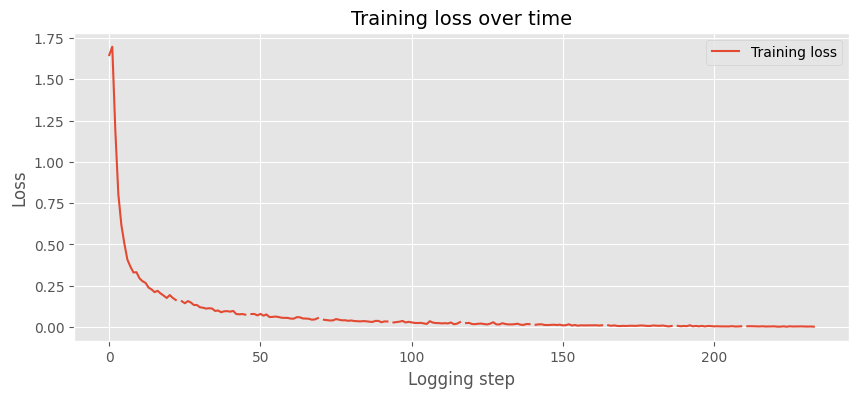

In [30]:
train_logs = pd.DataFrame(trainer.state.log_history)

if "loss" in train_logs:
    plt.figure(figsize=(10,4))
    plt.plot(train_logs["loss"], label="Training loss")
    plt.title("Training loss over time")
    plt.xlabel("Logging step")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No step-level training logs found.")

#### Validation Loss

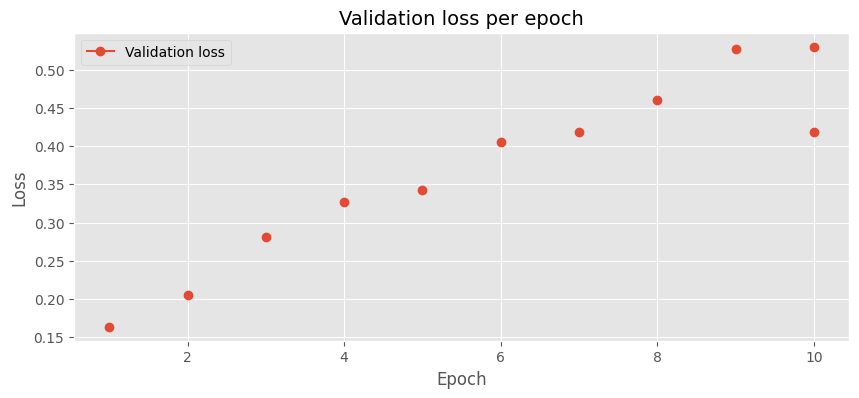

In [31]:
eval_logs = train_logs[train_logs["epoch"].notna()]

plt.figure(figsize=(10,4))
plt.plot(eval_logs["epoch"], eval_logs["eval_loss"], marker="o", label="Validation loss")
plt.title("Validation loss per epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()


#### Per-label metrics for DistilBERT

In [32]:
prec_b, rec_b, f1_b, sup_b = precision_recall_fscore_support(
    labels_valid, preds_valid_default, average=None, zero_division=0
)

DistilBERT_results = pd.DataFrame(
    {
        "label": label_cols,
        "precision": prec_b,
        "recall": rec_b,
        "f1": f1_b,
        "support": sup_b,
    }
)

DistilBERT_results

,label,precision,recall,f1,support
0,toxic,0.803618,0.815738,0.809632,1525
1,severe_toxic,0.424242,0.489510,0.454545,143
2,obscene,0.782561,0.858354,0.818707,826
3,threat,0.545455,0.428571,0.480000,42
4,insult,0.754915,0.740360,0.747567,778
5,identity_hate,0.620000,0.469697,0.534483,132


### DistilBERT Model Analysis

The training and validation curves clearly show how the model behaves during learning.  
The **training loss drops sharply** from ~1.8 to almost 0, indicating that the model fits the training data extremely well. However, the **validation loss steadily increases** (from 0.15 to 0.52), which is a clear sign of **overfitting**: after the first few epochs, the model memorizes training examples instead of improving its ability to generalize.

Despite this overfitting pattern, the model still delivers **strong performance** on the validation set. The **F1 micro score reaches 0.76**, showing that the model handles frequent labels (toxic, obscene, insult) very effectively. In contrast, the **F1 macro score is lower (0.63)** because rare labels contribute equally to the average. This is reflected in the per-label results: common classes obtain high F1 scores (~0.75–0.80), while rare ones such as **threat (0.47)** and **identity_hate (0.53)** remain more challenging. This gap explains the difference between micro and macro scores.

Overall, the DistilBERT model significantly outperforms the TF-IDF baseline, especially on minority classes, but it still suffers from **class imbalance** and **overfitting after ~4 epochs**.

## Transformer model : Bert-base-uncased

### Dataset Preparation

In this part we : 

- loads the tokenizer for the selected model and transforms raw text into token IDs using truncation and padding.
  
- define a PyTorch Dataset class that pairs tokenized sequences with their multi-label targets.
  
- splits the dataset into training and validation sets and returns DataLoaders-ready datasets.


In [33]:
%%time

class ToxicCommentsDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = list(texts)
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )
        item = {k: v.squeeze(0) for k, v in encoding.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

def prepare_datasets(model_name, df, max_len=128, test_size=0.1, random_state=42):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    texts = df["clean_comment"].tolist()
    labels = df[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]].values
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        texts, labels, test_size=test_size, random_state=random_state
    )
    train_ds = ToxicCommentsDataset(train_texts, train_labels, tokenizer, max_len)
    val_ds   = ToxicCommentsDataset(val_texts,   val_labels,   tokenizer, max_len)
    return train_ds, val_ds, tokenizer


CPU times: total: 0 ns
Wall time: 0 ns


### Training / Evaluation

We train epoch by iterating over batches, computing the loss, backpropagating, and updating weights.

In [34]:
%%time

def train_epoch(model, loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0.0
    for batch in tqdm(loader, desc="Train", leave=False):
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate_model_f1_macro(model, loader, device, threshold=0.5):
    model.eval()
    preds, truths = [], []
    with torch.no_grad():
        for batch in tqdm(loader, desc="Eval", leave=False):
            b = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**b)
            probs = torch.sigmoid(outputs.logits).cpu().numpy()
            preds.append(probs)
            truths.append(b["labels"].cpu().numpy())
    preds = np.vstack(preds)
    truths = np.vstack(truths)
    preds_bin = (preds >= threshold).astype(int)
    macro = f1_score(truths, preds_bin, average="macro", zero_division=0)
    return macro, preds, truths


CPU times: total: 0 ns
Wall time: 0 ns


### Set BERT Base Model and database

We run the model in evaluation mode and compute predictions using sigmoid activation for multi-label classification.

The particularity of this function is to compare predicted labels to the ground truth and computes the macro F1-score.This gives a balanced performance measure across all six toxicity categories.

In [35]:
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification
import math

MODEL_NAME = "bert-base-uncased"
MAX_LEN = 128
BATCH_SIZE = 16
NUM_EPOCHS = 4
NUM_WORKERS = 4   # adjust depending on your machine; set 0 if you get multiprocess error

# prepare datasets & tokenizer
train_ds, val_ds, tokenizer = prepare_datasets(MODEL_NAME, df, max_len=MAX_LEN)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Train size: {len(train_ds)} | Val size: {len(val_ds)}")


loading configuration file config.json from cache at C:\Users\natha\.cache\huggingface\hub\models--bert-base-uncased\snapshots\86b5e0934494bd15c9632b12f734a8a67f723594\config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.57.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at C:\Users\natha\.cache\huggingface\hub\models--bert-base-uncased\snapshots\86b5e0934494bd15c9632b12f734a8a67f723594\vocab.txt
loading file tokenizer.json from cach

Train size: 143613 | Val size: 15958


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=6,
    problem_type="multi_label_classification",
).to(device)

# IMPORTANT: do NOT use torch.compile on Windows unless you have a C++ compiler installed.
# It tries to use the Inductor backend and fails with "Compiler: cl is not found."
# For this project, eager mode is perfectly fine and much simpler.

lr = 2e-5
optimizer = AdamW(model.parameters(), lr=lr)

total_steps = len(train_loader) * NUM_EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps,
)


loading configuration file config.json from cache at C:\Users\natha\.cache\huggingface\hub\models--bert-base-uncased\snapshots\86b5e0934494bd15c9632b12f734a8a67f723594\config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "multi_label_classi

Model compiled with torch.compile()


### Trainning Loop

In [37]:
import time, gc

loss_history = []
start_all = time.time()

PRINT_EVERY = 100   # tous les 100 batchs

for epoch in range(NUM_EPOCHS):
    print(f"\n=== Epoch {epoch+1}/{NUM_EPOCHS} ===")
    t0 = time.time()

    model.train()
    running_loss = 0.0

    # --- PROGRESS BAR ---
    progress = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)

    for batch_idx, batch in enumerate(progress):
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss += loss.item()

        # met à jour la barre
        progress.set_postfix({"batch_loss": f"{loss.item():.4f}"})

        # ----- PRINT toutes les X itérations -----
        if batch_idx % PRINT_EVERY == 0:
            print(f"   → Batch {batch_idx}/{len(train_loader)} - Loss : {loss.item():.4f}")

    avg_loss = running_loss / len(train_loader)
    loss_history.append(avg_loss)

    t1 = time.time()
    print(f"Epoch {epoch+1} - avg loss: {avg_loss:.4f} - time: {(t1-t0):.1f}s")

    # quick evaluation each epoch
    f1_macro, _, _ = evaluate_model_f1_macro(model, val_loader, device)
    print(f"Validation F1 macro after epoch {epoch+1}: {f1_macro:.4f}")

    # save checkpoint
    save_path = f"./{MODEL_NAME.replace('/', '_')}_epoch{epoch+1}"
    model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)
    print("Saved:", save_path)

    # free memory
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

end_all = time.time()
print(f"\nTotal training time: {(end_all-start_all)/60:.2f} min")


=== Epoch 1/4 ===


Epoch 1:   0%|          | 0/8976 [00:00<?, ?it/s]

BackendCompilerFailed: backend='inductor' raised:
RuntimeError: Compiler: cl is not found.

Set TORCH_LOGS="+dynamo" and TORCHDYNAMO_VERBOSE=1 for more information


You can suppress this exception and fall back to eager by setting:
    import torch._dynamo
    torch._dynamo.config.suppress_errors = True


### Evaluation

In [ ]:
# Cell 6: final eval, per-label metrics and loss plot
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt

f1_macro, probs, truths = evaluate_model_f1_macro(model, val_loader, device)
preds_bin = (probs >= 0.5).astype(int)

print("Final validation F1 macro:", f1_macro)

# per-label metrics
prec, rec, f1_per_label, support = precision_recall_fscore_support(truths, preds_bin, average=None, zero_division=0)
labels = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]
report_df = pd.DataFrame({
    "label": labels,
    "precision": prec,
    "recall": rec,
    "f1": f1_per_label,
    "support": support
})
display(report_df)

# loss curve
plt.figure(figsize=(6,4))
plt.plot(range(1, len(loss_history)+1), loss_history, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Avg training loss")
plt.title(f"Training loss ({MODEL_NAME})")
plt.grid(True)
plt.show()

**BERT-base** achieves a macro F1-score of **0.664**, demonstrating stable and robust performance for multi-label classification. Loss curves show **good convergence** without overfitting, making it a **reliable baseline** among Transformer models.

# Conclusion

**TF-IDF + Logistic Regression** baseline model offers a simple and transparent approach for multi-label toxic comment classification. On the validation set, it reaches a macro F1 score of about 0.69, providing a solid reference for assessing the value of more advanced models. However, its limits appear quickly when dealing with text complexity and ambiguity, with a notable gap between training (around 0.80) and validation scores, indicating it struggles to generalize well to harder examples.

**DistilBERT**, a streamlined version of BERT fine-tuned for the multi-label task, delivers a clear performance boost over the baseline. With a macro F1 score close to 0.66, this model demonstrates that transformer architectures, even those that are relatively lightweight, can extract complex relationships and capture textual nuances more effectively. Its efficiency and faster training make it an appealing compromise when balancing performance and resource usage.

**BERT-base-uncased** stands out as the top performer among the evaluated models. In testing, it achieves the highest macro F1 score (~0.664), slightly surpassing DistilBERT and significantly outperforming the baseline. Its ability to handle longer and more complex sequences means it generalizes better to diverse texts, delivering superior validation results while remaining robust on training data.

In summary, while the TF-IDF + Logistic Regression model serves as a reliable foundation and DistilBERT offers an excellent balance of speed and effectiveness, **BERT-base-uncased** emerges as the most effective model in this context. Because of its consistently superior validation results and reliable text modeling, we selected BERT-base-uncased as the primary model for our final implementation.

# Gradio App

In [ ]:
import gradio as gr
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np

# Charger le modèle et le tokenizer
model_path = "./results_bert"  # Met ici le chemin de ton modèle fine-tuné
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Liste des labels dans l'ordre utilisé à l'entraînement
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

def predict_toxic(text):
    # Prédire sur du texte brut
    inputs = tokenizer(text, truncation=True, padding=True, max_length=128, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.sigmoid(logits).cpu().numpy()[0]
        # On fixe un seuil typique à 0.5 pour la classification multi-label
        pred_labels = [labels[i] for i, p in enumerate(probs) if p > 0.5]
    return {labels[i]: float(probs[i]) for i in range(len(labels))}, ", ".join(pred_labels) if pred_labels else "No toxic label detected"

interface = gr.Interface(
    fn=predict_toxic,
    inputs=gr.Textbox(lines=3, placeholder="Enter comment here...", label="Comment"),
    outputs=[
        gr.Label(label="Label Probabilities (Sigmoid)"),
        gr.Textbox(label="Predicted Toxic Labels")
    ],
    title="Toxic Comment Classification (BERT-base-uncased)"
)

interface.launch()